In [1]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4
# Set the HF_HOME environment variable
os.environ["HF_HOME"] = "/run/media/HUNK/DATASETS/HF"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
# Declare a few global data/train params
from lib.optim import WarmupCosineLR
from data.fenEval import *
from extras.train import GPTTrainer


class params:
    num_workers = 24
    batch_size = 64
    seq_len = 80

    max_epochs = 10000
    lr = 0.005

    epoch_every = 2000


dt = FENEval(DataConfig.create(params))

# dt.preview()

data[-1] counts in label order from 0:
1: 1445510
2: 1418018
3: 1001538
4: 697499
5: 514982
6: 424916
7: 363042
8: 324951
9: 287934
10: 2246582
11: 2504269
12: 922331
13: 621565
14: 461790
15: 369905
16: 321701
17: 283731
18: 263365
19: 239210
20: 1873688


In [11]:
# function defs


def evaluate(trainer):
    eval_ms = MetricsFrame(
        [
            from_te(
                ms.MulticlassConfusionMatrix,
                "ConfusionMatrix",
                num_classes=dt.classes,
            ),
            from_te(
                ms.MulticlassAccuracy,
                "Accuracy",
                num_classes=dt.classes,
            ),
            from_te(
                ms.MulticlassPrecision,
                "WeightedPrecision",
                average="weighted",
                num_classes=dt.classes,
            ),
            from_te(
                ms.MulticlassRecall,
                "WeightedRecall",
                average="weighted",
                num_classes=dt.classes,
            ),
        ],
        flush_every=0,
        xlabel=None,
    )

    trainer.eval(
        pred=True,
        loss=True,
        mfs=eval_ms,
    )
    plot_2dheatmap(
        eval_ms.dict["ConfusionMatrix"][0],
        ticklabels=[
            "0.5",
            "1.0",
            "1.5",
            "2.0",
            "2.5",
            "3.0",
            "3.5",
            "4.0",
            "4.5",
            "> 4.5",
            "0",
            "-0.5",
            "-1.0",
            "-1.5",
            "-2.0",
            "-2.5",
            "-3.0",
            "-3.5",
            "-4.0",
            "< -4.5",
        ],
    )
    print({k: v for k, v in eval_ms.dict.items() if k != "ConfusionMatrix"})
    return eval_ms.dict["ConfusionMatrix"][0]


In [4]:
# train rwkv

from models.nanoRWKV_ViT import *

model = RWKV_ViT(
    GPT_ViTConfig(
        vocab_size=dt.vocab,
        n_classes=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)

print(model)
trainer = GPTTrainer(
    TrainerConfig.create(
        params,
        save_model_every=20,
        load_previous=True,
    )
)

number of parameters: 85.18M
RWKV_ViT(
  (transformer): ModuleDict(
    (wte): Embedding(34, 768)
    (wpe): Embedding(80, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (tmix): RWKV_TimeMix_x051a(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (gate): Linear(in_features=768, out_features=768, bias=True)
          (output): Linear(in_features=768, out_features=768, bias=True)
          (ln_x): GroupNorm(12, 768, eps=0.00064, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (cmix): RWKV_ChannelMix_x051a(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): Linear(in_features=768, out_features=2304, bias=Tr

In [5]:
trainer.init(model, dt.loaders())
# trainer.fit()

RWKV_ViT__seq_len=80__vocab_size=34__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__n_classes=20*__epoch=*.pth
Found older file: RWKV_ViT__seq_len=80__vocab_size=34__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__n_classes=20__lr=0.005__weight_decay=0.01__epoch=3-3.pth
Loading.....


/ARCHIVE/Personal/2186474940/lib/train.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(files[-1])


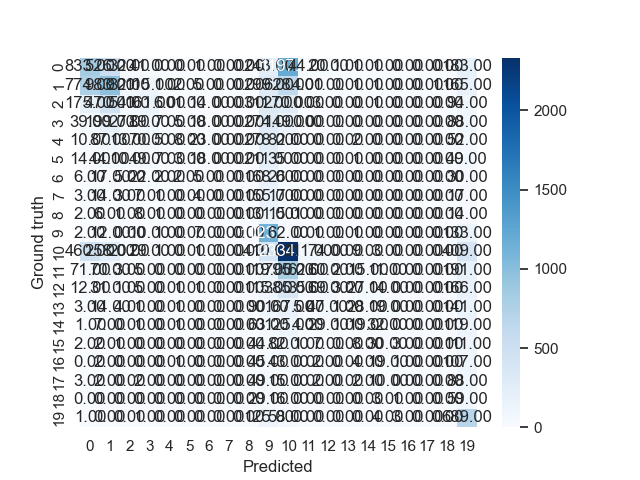

{'Accuracy': [0.3038487434387207], 'WeightedPrecision': [0.2688777446746826], 'WeightedRecall': [0.3038487434387207], 'batch': [324]}


In [11]:
# trainer.save_model()
evaluate(trainer)


{'Accuracy': [0.28812578320503235], 'WeightedPrecision': [0.28152918815612793], 'WeightedRecall': [0.28812575340270996]}

In [4]:
# train rwkv

from models.nanoGPT_ViT import *

model = GPT_ViT(
    GPT_ViTConfig(
        vocab_size=dt.vocab,
        n_classes=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)

print(model)
trainer = GPTTrainer(
    TrainerConfig.create(
        params,
        load_previous=True,
        epoch_every=50,
    )
)


number of parameters: 85.10M
GPT_ViT(
  (transformer): ModuleDict(
    (wte): Embedding(34, 768)
    (wpe): Embedding(80, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=20, bias=False)
)


Skipping load. No older file found.


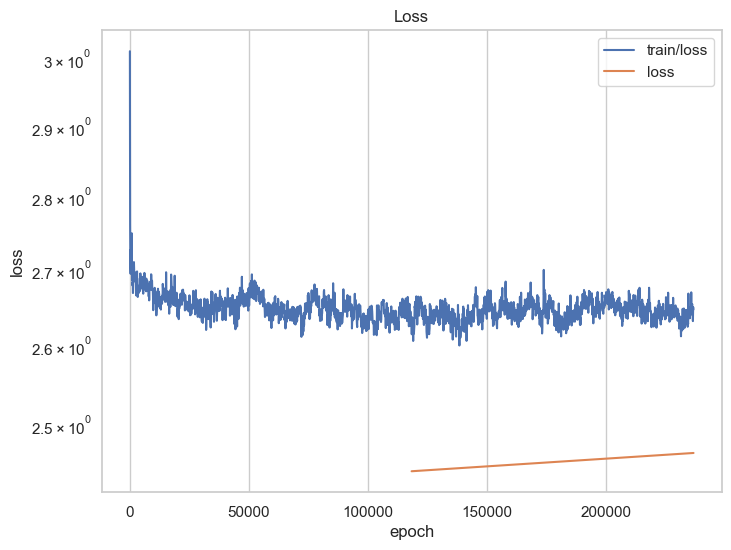

Epochs progress:   0%|          | 0/2 [00:00<?, ?Epoch/s]

/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  self.pid = os.fork()
/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and 

tensor(0.0031, device='cuda:0')

In [5]:
trainer.init(model, dt.loaders())
trainer.fit()


In [7]:
trainer.save_model()

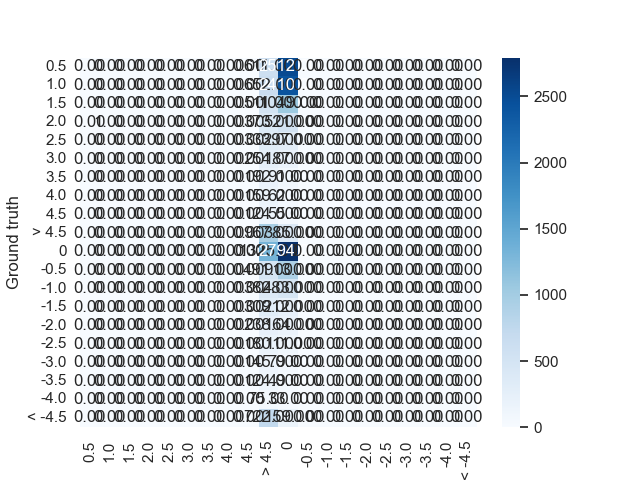

{'Accuracy': [0.1813928782939911], 'WeightedPrecision': [0.05189180001616478], 'WeightedRecall': [0.1813928782939911], 'batch': [324]}


In [12]:
result = evaluate(trainer)
